# Portfolio optimization 

### Portfolio allocation vector

In this example we show how to do portfolio optimization using CVXPY.
We begin with the basic definitions.
In portfolio optimization we have some amount of money to invest in any of $n$ different assets. 
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.

We call $w\in {\bf R}^n$ the *portfolio allocation vector*.
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a *short position* in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a *long only* portfolio.
The quantity
$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w_- $$
is known as *leverage*.

### Asset returns

We will only model investments held for one period. The initial prices are $p_i > 0$. The end of period prices are $p_i^+ >0$. The asset (fractional) returns are $r_i = (p_i^+-p_i)/p_i$. The porfolio (fractional) return is $R = r^Tw$.

A common model is that $r$ is a random variable with mean ${\bf E}r = \mu$ and covariance ${\bf E{(r-\mu)(r-\mu)^T}} = \Sigma$.
It follows that $R$ is a random variable with ${\bf E}R = \mu^T w$ and ${\bf var}(R) = w^T\Sigma w$.
${\bf E}R$ is the (mean) *return* of the portfolio. ${\bf var}(R)$ is the *risk* of the portfolio.
(Risk is also sometimes given as ${\bf std}(R) = \sqrt{{\bf var}(R)}$.)

Portfolio optimization has two competing objectives: high return and low risk.

### Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{subject to} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.

The objective $\mu^Tw - \gamma w^T\Sigma w$ is the *risk-adjusted return*. Varying $\gamma$ gives the optimal *risk-return trade-off*. 
We can get the same risk-return trade-off by fixing return and minimizing risk.

### Example

In the following code we compute and plot the optimal risk-return trade-off for $10$ assets, restricting ourselves to a long only portfolio.

In [1]:
# Generate data for long only portfolio optimization.
import numpy as np
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [2]:
# Long only portfolio optimization.
import cvxpy as cp


w = cp.Variable(n)
gamma = cp.Parameter(nonneg=True)
ret = mu.T*w 
risk = cp.quad_form(w, Sigma)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                w >= 0])

In [3]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = cp.sqrt(risk).value
    ret_data[i] = ret.value

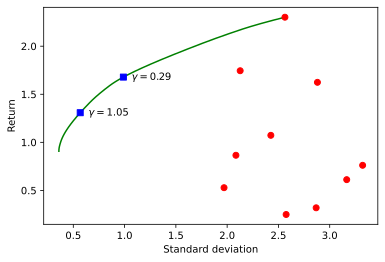

In [4]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(cp.sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

We plot below the return distributions for the two risk aversion values marked on the trade-off curve.
Notice that the probability of a loss is near 0 for the low risk value and far above 0 for the high risk value.

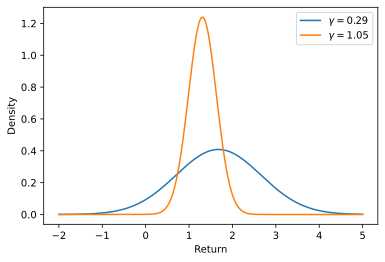

In [5]:
# Plot return distributions for two points on the trade-off curve.
import scipy.stats as spstats


plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, spstats.norm.pdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

### Portfolio constraints

There are many other possible portfolio constraints besides the long only constraint. With no constraint (${\cal W} = {\bf R}^n$), the optimization problem has a simple analytical solution. We will look in detail at a *leverage limit*, or the constraint that $\|w \|_1 \leq L^\mathrm{max}$.


Another interesting constraint is the *market neutral* constraint $m^T \Sigma w =0$, where $m_i$ is the capitalization of asset $i$.
$M = m^Tr$ is the *market return*, and $m^T \Sigma w = {\bf cov}(M,R)$.
The market neutral constraint ensures that the portfolio return is uncorrelated with the market return.

### Example

In the following code we compute and plot optimal risk-return trade-off curves for leverage limits of 1, 2, and 4.
Notice that more leverage increases returns and allows greater risk.

In [6]:
# Portfolio optimization with leverage limit.
Lmax = cp.Parameter()
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

In [7]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve(solver=cp.SCS)
        risk_data[k, i] = cp.sqrt(risk).value
        ret_data[k, i] = ret.value

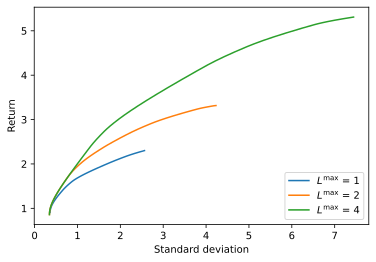

In [8]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(cp.sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

We next examine the points on each trade-off curve where $w^T\Sigma w = 2$.
We plot the amount of each asset held in each portfolio as bar graphs. (Negative holdings indicate a short position.)
Notice that some assets are held in a long position for the low leverage portfolio but in a short position in the higher leverage portfolios. 

In [9]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = cp.Problem(cp.Maximize(ret), 
              [cp.sum(w) == 1, 
               cp.norm(w, 1) <= Lmax,
               risk <= 2])

In [10]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

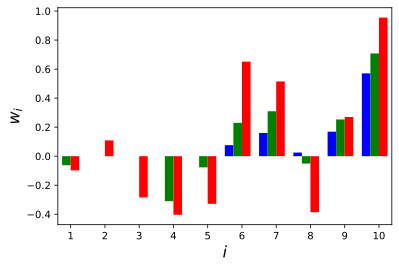

In [11]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, w_vals[idx][indices], color=colors[idx], 
             label=r"$L^{\max}$ = %d" % L_val, width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.show()

### Variations

There are many more variations of classical portfolio optimization. We might require that $\mu^T w \geq R^\mathrm{min}$ and minimize $w^T \Sigma w$ or $\|\Sigma ^{1/2} w\|_2$.
We could include the (broker) cost of short positions as the penalty $s^T (w)_-$ for some $s \geq 0$.
We could include transaction costs (from a previous portfolio $w^\mathrm{prev}$) as the penalty

$$
\kappa ^T |w-w^\mathrm{prev}|^\eta, \quad
\kappa \geq 0.
$$


Common values of $\eta$ are $\eta =1, ~ 3/2, ~2$.


### Factor covariance model

A particularly common and useful variation is to model the covariance matrix $\Sigma$ as a factor model

$$
\Sigma  =  F \tilde \Sigma F^T + D,
$$

where  $F \in {\bf R}^{n \times k}$, $k \ll n$ is the *factor loading matrix*. $k$ is the number of factors (or sectors) (typically 10s). $F_{ij}$ is the loading of asset $i$ to factor $j$.
$D$ is a diagonal matrix; $D_{ii}>0$ is the *idiosyncratic risk*. $\tilde \Sigma > 0$ is the *factor covariance matrix*.

$F^Tw \in {\bf R}^k$ gives the portfolio *factor exposures*. A portfolio is *factor $j$ neutral* if $(F^Tw)_j=0$.


### Portfolio optimization with factor covariance model

Using the factor covariance model, we frame the portfolio optimization problem as 

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma \left(f^T \tilde \Sigma f  + w^TDw \right) \\
\mbox{subject to} & {\bf 1}^T w = 1, \quad f=F^Tw\\
& w \in {\cal W}, \quad f \in {\cal F},
\end{array}

where the variables are the allocations $w \in {\bf R}^n$ and factor exposures $f\in {\bf R}^k$ and $\cal F$ gives the factor exposure constraints.

Using the factor covariance model in the optimization problem has a computational advantage. The solve time is $O(nk^2)$ versus $O(n^3)$ for the standard problem.

### Example

In the following code we generate and solve a portfolio optimization problem with 50 factors and 3000 assets.
We set the leverage limit $=2$ and $\gamma=0.1$.

We solve the problem both with the covariance given as a single matrix and as a factor model.
Using CVXPY with the OSQP solver running in a single thread, the solve time was 173.30 seconds for the single matrix formulation and 0.85 seconds for the factor model formulation.
We collected the timings on a MacBook Air with an Intel Core i7 processor.

In [12]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [13]:
# Factor model portfolio optimization.
w = cp.Variable(n)
f = F.T*w
gamma = cp.Parameter(nonneg=True)
Lmax = cp.Parameter()
ret = mu.T*w 
risk = cp.quad_form(f, Sigma_tilde) + cp.quad_form(w, D)
prob_factor = cp.Problem(cp.Maximize(ret - gamma*risk), 
                     [cp.sum(w) == 1, 
                      cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 6050, constraints m = 6052
          nnz(P) + nnz(A) = 172325
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -2.1359e+03   7.63e+00   3.73e+02   1.00e-01   6.21e-02s
 200  -4.1946e+00   1.59e-03   7.86e-03   3.60e-01   4.00e-01s
 400  -4.6288e+00   3.02e-04   6.01e-04 

4.606413081938858

In [21]:
# Standard portfolio optimization with data from factor model.
risk = cp.quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
               [cp.sum(w) == 1, 
                cp.norm(w, 1) <= Lmax])

prob.solve(solver=cp.ECOS)

4.601466743013098

In [22]:
print('Factor model solve time = {}'.format(prob_factor.solver_stats.solve_time))
print('Single model solve time = {}'.format(prob.solver_stats.solve_time))

Factor model solve time = 2.485396595
Single model solve time = 864.747778202
